In [60]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34

In [14]:
G = 6.67e-11
M0 = 2e30
c = 3e8

def chirp_rate(f,Mc):
    return 96/5*np.pi*(np.pi*G*Mc/c**3)**(5/3)*f**(11/3)



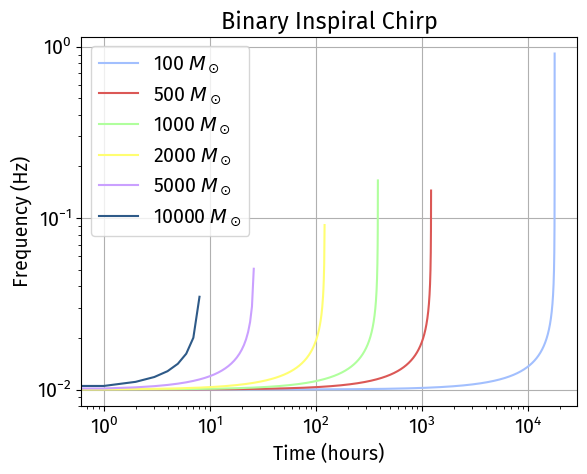

In [15]:
def chirp_constant(Mc):
    return (96/5) * np.pi**(8/3) * (G * Mc / c**3)**(5/3)

def f_t(t, f0, Mc):
    k = chirp_constant(Mc)
    return (f0**(-8/3) - (8/3) * k * t)**(-3/8)


masses = [100,500,1000,2000,5000,10000]
# Parameters

for M in masses:
    Mc = M * M0  # chirp mass in kg (example: 30 solar masses)
    f0 = 1/100         # starting frequency in Hz
    t_end = 3600*100000       # seconds until merger
    t = np.linspace(0, t_end, 100000)

    # Compute frequency evolution
    f = f_t(t, f0, Mc)

    # Plot
    plt.plot(t/3600, f, label = "%d $M_\odot$"%M)
    plt.xlabel("Time (hours)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Binary Inspiral Chirp")
    # ax1.ylim([1/640,1/10])
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    
ax1.legend()
plt.savefig('inspiral_chirps.pdf')

In [16]:
d = 1e10
c = 3e8


def smooth_abs(x, eps=1e-12):
    return np.sqrt(x**2 + eps)


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg

def find_T(t0,f_chirp):
    def integral_minus_one(T):
        integral, _ = quad(f_chirp, t0, t0 + T)
        return integral - 1.0
    sol = root_scalar(integral_minus_one, bracket=[0, 1/f_chirp(t0)], method='brentq')
    return sol.root
def find_T_minimize(t0, f_chirp):
    """
    Find cycle duration by minimizing the waveform difference.
    """
    def cycle_err(T_array):
        T = T_array[0]  # extract scalar from array
        cyc_start = h_chirped(t0, 1, f_chirp(t0), 0) - h_chirped(t0 + d/c, 1, f_chirp(t0 + d/c), 0)
        cyc_end   = h_chirped(t0 + T, 1, f_chirp(t0+T), 0) - h_chirped(t0 + T + d/c, 1, f_chirp(t0 + T + d/c), 0)
        return smooth_abs(cyc_start - cyc_end)

    # Initial guess: instantaneous period
    T0 = np.array([1 / f_chirp(t0)])

    res = sco.minimize(cycle_err, T0, bounds=[(0, None)], method='Nelder-Mead')

    if not res.success:
        raise RuntimeError("Minimization failed: " + res.message)
    
    return res.x[0]

def h_chirped(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 

def signal(t0,T=160,H= 1e-20,f = 1/160,phi = 0,dd_pi_pulses = 1):
    
    ts = np.linspace(t0,t0+T,10000)
    dt = ts[1]-ts[0]
    s = 1/2*(h(ts,H,f,phi)-h(ts+d/c,H,f,phi))
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return s_bar

def signal_chirped(t0,f_chirp,H= 1e-20,phi = 0,dd_pi_pulses = 1,fixed_T = False, T = 100, optimized_T = True):
    if fixed_T == False:
        T = 1/f_chirp(t0)
    if optimized_T:
        T = find_T_minimize(t0,f_chirp)

       
    ts = np.linspace(t0,t0+T,40000)
    # ax1.figure()
    dt = ts[1]-ts[0]
    s = 1/2*(h_chirped(ts,H,f_chirp(ts),phi)-h_chirped(ts+d/c,H,f_chirp(ts+d/c),phi))
    # ax1.plot(ts,s)
    # print(s[0]-s[-1])
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return (s_bar,T)






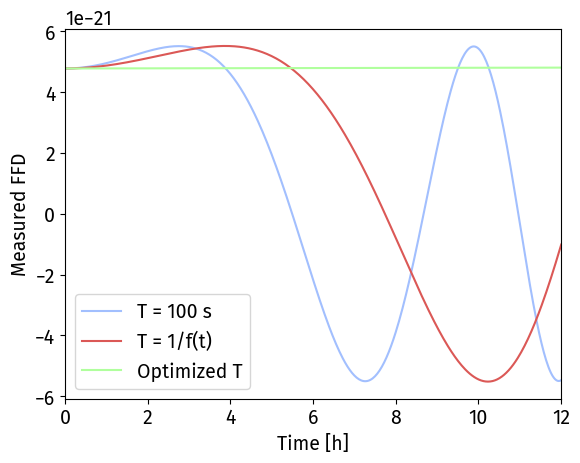

In [21]:
t0 = 0
signals1 = []
t0s1 = []
for i in range(1200):
    s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi = 0,dd_pi_pulses = 1,fixed_T = True,optimized_T = False)
    t0 = t0+T
    t0s1.append(t0)
    signals1.append(s_bar)
plt.plot(np.array(t0s1)/3600,signals1,label = 'T = 100 s')

t0 = 0
signals2 = []
t0s2 = []
for i in range(1200):
    s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi = 0,dd_pi_pulses = 1,fixed_T = False,optimized_T = False)
    t0 = t0+T
    t0s2.append(t0)
    signals2.append(s_bar)
    
plt.plot(np.array(t0s2)/3600,signals2,label = 'T = 1/f(t)')

t0 = 0
signals3 = []
t0s3 = []
for i in range(1200):
    s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi = 0,dd_pi_pulses = 1,fixed_T = True,optimized_T = True)
    t0 = t0+T
    t0s3.append(t0)
    signals3.append(s_bar)
    
plt.plot(np.array(t0s3)/3600,signals3,label = 'Optimized T')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Measured FFD')
plt.xlim([0,12])
plt.savefig('plots/chirping_signal.pdf')


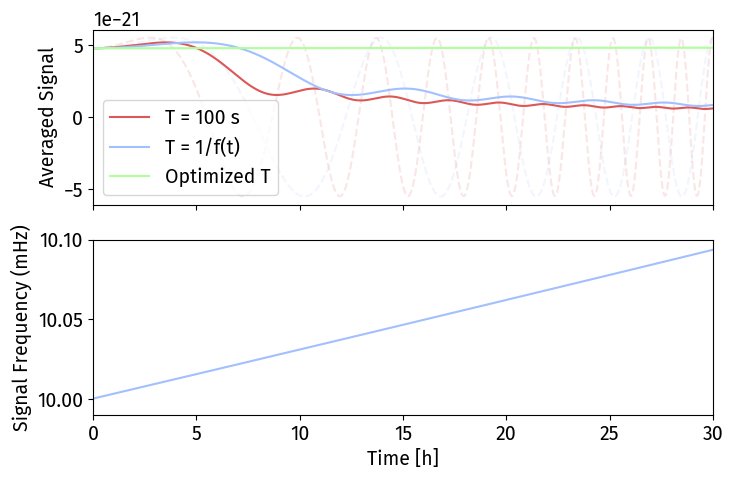

In [19]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize = (8,5), sharex = True)

ax1.plot(np.array(t0s1)/3600,signals1,color = RED,alpha = 0.15,linestyle = '--')
ax1.plot(np.array(t0s2)/3600,signals2,color = BLUE,alpha = 0.15,linestyle = '--')
ax1.plot(np.array(t0s3)/3600,signals3,color = GREEN,alpha = 0.15,linestyle = '--')


avg1 = np.cumsum(np.array(signals1)) / np.arange(1, len(signals1) + 1)
avg2 = np.cumsum(np.array(signals2)) / np.arange(1, len(signals2) + 1)
avg3 = np.cumsum(np.array(signals3)) / np.arange(1, len(signals3) + 1)


ax1.plot(np.array(t0s1)/3600,avg1,label = 'T = 100 s',color = RED)
ax1.plot(np.array(t0s2)/3600,avg2,label = 'T = 1/f(t)',color = BLUE)
ax1.plot(np.array(t0s3)/3600,avg3,label = 'Optimized T',color = GREEN)


ax1.legend()
ax2.set_xlabel('Time [h]')
ax1.set_ylabel('Averaged Signal')
ax2.set_ylabel('Signal Frequency (mHz)')
ax2.plot(t/3600,f*1000)

ax2.set_xlim([0,30])
ax2.set_ylim([9.99,10.1])

plt.savefig('plots/chirping_signal_average.pdf')


In [52]:
def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)


def generate_signals(f0,N_measurements,M_chirp,phi,t0):
    t = np.linspace(0, 50*3600, 10000) 
    Mc = M_chirp*M0
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    t0 = t0
    signals = []
    t0s1 = []
    for i in range(1200):
        s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi=phi,dd_pi_pulses = 1,fixed_T = False,optimized_T = True)
        t0 = t0+T
        t0s1.append(t0)
        signals.append(s_bar)
    return signals

def generate_signals_inst_T(f0,N_measurements,M_chirp,phi,t0):
    t = np.linspace(0, 50*3600, 10000) 
    Mc = M_chirp*M0
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    t0 = t0
    signals = []
    t0s1 = []
    for i in range(1200):
        s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi=phi,dd_pi_pulses = 1,fixed_T = False,optimized_T = False)
        t0 = t0+T
        t0s1.append(t0)
        signals.append(s_bar)
    return signals

def generate_signals_fixed_T(f0,N_measurements,M_chirp,phi,t0):
    t = np.linspace(0, 50*3600, 10000) 
    Mc = M_chirp*M0
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    t0 = t0
    signals = []
    t0s1 = []
    for i in range(1200):
        s_bar,T = signal_chirped(t0,H= 1e-20,f_chirp = f_chirp,phi=phi,dd_pi_pulses = 1,fixed_T = True,optimized_T = False)
        t0 = t0+T
        t0s1.append(t0)
        signals.append(s_bar)
    return signals




    

def clock_average(signals,N = 1e7,offset = np.pi/10):

    P1 = []
    P2 = []
    pll_noise = laser_phase_noise(0.001,1e-10,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal in tqdm(signals, leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        P1.append(p1)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        P2.append(p2)
    P1 = np.squeeze(P1)
    P2 = np.squeeze(P2)
    
    data = np.array(list(zip(P1,P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    phi_measured = opt[0]
    phi_err = opt[1]
    return np.array(phi_measured)-offset,np.array(phis_err)
    

In [50]:
signals = generate_signals(0.01,1200,500,0,0)


In [ ]:
clock_average(signals,)

NameError: name 'h_const' is not defined